# Preprocess Datasets for Korean LLM (Large Language Model) fine-tuning
---

- Alpaca 논문에서 전처리했던 방식대로 전처리 수행
- 허깅페이스 인증 정보 설정: `huggingface-cli login`
    - https://huggingface.co/join
    - https://huggingface.co/settings/tokens

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('./utils')
sys.path.append('./templates')

from common_lib import check_packages
check_packages()

<br>

## 1. Download LLM from Hugging Face hub
---

### Load dataset
허깅페이스 허브에서 다운로드하거나 json/json 포맷의 데이터 세트를 다운로드합니다. 데이터 세트 내 샘플은 (`instruction, input, output`)의 
key-value나 (`instruction, output`)의 key-value로 구성되어야 합니다.

구름 데이터셋 v2는 GPT-4-LLM, Vicuna, 그리고 Databricks의 Dolly 데이터셋을 병합한 것입니다. 이 모든 데이터셋은 DeepL을 이용하여 한국어로 번역되었습니다.
https://huggingface.co/datasets/nlpai-lab/kullm-v2

예시:
```
{
    "instruction":"건강을 유지하기 위한 세 가지 팁을 알려주세요.",
    "input":"",
    "output":"세 가지 팁은 아침식사를 꼭 챙기며, 충분한 수면을 취하고, 적극적으로 운동을 하는 것입니다."
}
```

In [2]:
import os
import torch
import transformers
from datasets import load_dataset
from inference_lib import Prompter
from transformers import GPTNeoXForCausalLM, GPTNeoXTokenizerFast

data_path = "nlpai-lab/kullm-v2"
#data_path = "beomi/KoAlpaca-v1.1a"
#data_path = "./data/ko_alpaca_data.json"

if data_path.endswith(".json") or data_path.endswith(".jsonl"):
    data = load_dataset("json", data_files=data_path)
else:
    data = load_dataset(data_path)
    
prompter = Prompter("kullm")
cutoff_len = 2048
train_on_inputs = True

In [3]:
data_path

'nlpai-lab/kullm-v2'

In [4]:
import os
from pathlib import Path
from huggingface_hub import snapshot_download

HF_MODEL_ID = "nlpai-lab/kullm-polyglot-12.8b-v2"

tokenizer = GPTNeoXTokenizerFast.from_pretrained(HF_MODEL_ID)

# Only download pytorch checkpoint files
allow_patterns = ["*.json", "*.pt", "*.bin", "*.txt", "*.model"]

# create model dir
model_name = HF_MODEL_ID.split("/")[-1].replace('.', '-')
model_tar_dir = Path(f"/home/ec2-user/SageMaker/models/{model_name}")
if not os.path.isdir(model_tar_dir):
    os.makedirs(model_tar_dir, exist_ok=True)
    # Download model from Hugging Face into model_dir
    snapshot_download(
        HF_MODEL_ID, 
        local_dir=str(model_tar_dir), 
        local_dir_use_symlinks=False,
        allow_patterns=allow_patterns,
        cache_dir="/home/ec2-user/SageMaker/"
    )

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'PreTrainedTokenizerFast'. 
The class this function is called from is 'GPTNeoXTokenizerFast'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# 입력 데이터셋 살펴보기 EDA

데이터 구조
- id: 각 데이터 포인트의 고유 식별자
- instruction: 사용자의 질문 또는 명령
- input: 추가 입력 (여기서는 비어 있음)
- output: 질문 또는 명령에 대한 답변

In [5]:
# 데이터셋의 처음 3개 샘플을 출력
print(data['train'][:3])

{'id': ['alpaca_{idx}', 'alpaca_{idx}', 'alpaca_{idx}'], 'instruction': ['3원색이란 무엇인가요?', '어려운 결정을 내려야 했던 순간을 설명해 주세요.', '원자의 구조를 설명합니다.'], 'input': ['', '', ''], 'output': ['세 가지 기본 색은 빨강, 파랑, 노랑입니다. 이 색은 다른 색을 혼합하여 만들 수 없고 다른 모든 색은 다양한 비율로 조합하여 만들 수 있기 때문에 원색이라고 부릅니다. 빛에 사용되는 첨가제 색상 시스템에서 원색은 빨강, 녹색, 파랑(RGB)입니다.', 'AI 어시스턴트인 저는 저만의 개인적인 경험이나 물리적 존재를 가지고 있지 않습니다. 하지만 알고리즘, 논리, 데이터를 기반으로 의사 결정을 내리도록 프로그래밍되어 있습니다. 상충되는 정보나 여러 가지 가능한 결과가 있을 수 있기 때문에 의사결정이 어려운 상황에 직면할 때가 있습니다. 그런 경우 저는 각 옵션의 위험과 이점을 분석하고 비교하여 원하는 결과를 얻을 가능성이 가장 높은 결론에 도달할 수 있는 능력을 활용합니다.', '원자는 모든 물질의 기본 구성 요소이며 양성자, 중성자, 전자의 세 가지 유형의 입자로 이루어져 있습니다. 원자의 구조는 전자 구름으로 둘러싸인 중앙에 핵이 있는 것으로 설명할 수 있습니다.\n\n원자의 핵은 양성자와 중성자로 구성됩니다. 양성자는 양전하를 띠는 입자이고 중성자는 전하를 띠지 않는 중성 입자입니다. 이 두 입자는 원자의 중심에 있으며 원자 질량의 대부분을 차지하는 원자핵에 위치합니다.\n\n원자핵을 둘러싸고 있는 것은 전자 구름입니다. 전자는 음전하를 띠는 입자로, 원자핵 주변에서 끊임없이 움직입니다. 전자 구름은 껍질 또는 궤도로 나뉘며, 각 껍질은 특정 수의 전자를 보유할 수 있습니다. 원자가 껍질이라고 하는 가장 바깥쪽 껍질에 있는 전자의 수에 따라 원자의 화학적 특성이 결정됩니다.\n\n중성 원자에서 핵의 양성자 수는 전자 구름의 전자 수와 같으므로 양전

### 기본 통계량 계산
문장의 길이, 단어의 개수, 고유 단어의 개수 등을 계산합니다.

In [6]:
import pandas as pd

# 데이터셋을 pandas DataFrame으로 변환
df = pd.DataFrame(data['train'])

df

,id,instruction,input,output
0,alpaca_{idx},3원색이란 무엇인가요?,,"세 가지 기본 색은 빨강, 파랑, 노랑입니다. 이 색은 다른 색을 혼합하여 만들 수..."
1,alpaca_{idx},어려운 결정을 내려야 했던 순간을 설명해 주세요.,,AI 어시스턴트인 저는 저만의 개인적인 경험이나 물리적 존재를 가지고 있지 않습니다...
2,alpaca_{idx},원자의 구조를 설명합니다.,,"원자는 모든 물질의 기본 구성 요소이며 양성자, 중성자, 전자의 세 가지 유형의 입..."
3,alpaca_{idx},대기 오염을 줄이려면 어떻게 해야 할까요?,,대기 오염을 줄이는 방법에는 다음과 같은 여러 가지가 있습니다:\n\n1. 에너지 ...
4,alpaca_{idx},건강을 유지하기 위한 세 가지 팁을 알려주세요.,,"1. 균형 잡힌 영양가 있는 식단을 섭취합니다: 식단에 다양한 과일과 채소, 저지방..."
...,...,...,...,...
152625,vicuna_{idx},자세히 보기,,7가지 동영상 제목 아이디어가 더 있습니다:1. 시청자를 교육하고 신뢰를 구축하는 ...
152626,vicuna_{idx},"저는 다양한 직원의 순간(온보딩부터 오프보딩까지, 그리고 그 사이에 결혼, 질병 등...",,직원의 중요한 순간을 위한 허브 사이트를 만들게 된 것을 축하합니다! 퇴직을 오프보...
152627,vicuna_{idx},이미지가 PDF로 저장됩니다. 다르게 처리해야 하나요? 일부 PDF에는 이러한 출석...,,"예, PDF 페이지에서 이미지를 먼저 추출해야 하므로 PDF 파일을 다른 방식으로 ..."
152628,vicuna_{idx},더 많은 아이디어 제공,,비감염성 질환 문제를 해결하기 위한 웹사이트 아이디어를 몇 가지 더 소개합니다:1....


In [9]:
# 문장 길이, 단어 수 등 기본 통계량 계산
df['instruction_length'] = df['instruction'].apply(len)
df['input_length'] = df['input'].apply(len)
df['output_length'] = df['output'].apply(len)

print(df.describe())
df

       instruction_length   input_length  output_length
count       152630.000000  152630.000000  152630.000000
mean           159.659209      21.391404     653.133519
std            571.326172     149.934448     617.208994
min              0.000000       0.000000       0.000000
25%             23.000000       0.000000     171.000000
50%             33.000000       0.000000     529.000000
75%             57.000000       0.000000     912.000000
max          23515.000000    9244.000000    6079.000000


,id,instruction,input,output,instruction_length,input_length,output_length
0,alpaca_{idx},3원색이란 무엇인가요?,,"세 가지 기본 색은 빨강, 파랑, 노랑입니다. 이 색은 다른 색을 혼합하여 만들 수...",12,0,140
1,alpaca_{idx},어려운 결정을 내려야 했던 순간을 설명해 주세요.,,AI 어시스턴트인 저는 저만의 개인적인 경험이나 물리적 존재를 가지고 있지 않습니다...,27,0,238
2,alpaca_{idx},원자의 구조를 설명합니다.,,"원자는 모든 물질의 기본 구성 요소이며 양성자, 중성자, 전자의 세 가지 유형의 입...",14,0,508
3,alpaca_{idx},대기 오염을 줄이려면 어떻게 해야 할까요?,,대기 오염을 줄이는 방법에는 다음과 같은 여러 가지가 있습니다:\n\n1. 에너지 ...,23,0,712
4,alpaca_{idx},건강을 유지하기 위한 세 가지 팁을 알려주세요.,,"1. 균형 잡힌 영양가 있는 식단을 섭취합니다: 식단에 다양한 과일과 채소, 저지방...",26,0,402
...,...,...,...,...,...,...,...
152625,vicuna_{idx},자세히 보기,,7가지 동영상 제목 아이디어가 더 있습니다:1. 시청자를 교육하고 신뢰를 구축하는 ...,7,0,280
152626,vicuna_{idx},"저는 다양한 직원의 순간(온보딩부터 오프보딩까지, 그리고 그 사이에 결혼, 질병 등...",,직원의 중요한 순간을 위한 허브 사이트를 만들게 된 것을 축하합니다! 퇴직을 오프보...,141,0,1000
152627,vicuna_{idx},이미지가 PDF로 저장됩니다. 다르게 처리해야 하나요? 일부 PDF에는 이러한 출석...,,"예, PDF 페이지에서 이미지를 먼저 추출해야 하므로 PDF 파일을 다른 방식으로 ...",80,0,1532
152628,vicuna_{idx},더 많은 아이디어 제공,,비감염성 질환 문제를 해결하기 위한 웹사이트 아이디어를 몇 가지 더 소개합니다:1....,12,0,1222


In [ ]:
!pip install seaborn

### 각각 칼럼별 문장들의 분포를 시각화

로그 스케일은 특히 값의 범위가 넓거나, 작은 값들의 분포가 중요할 때 유용합니다.

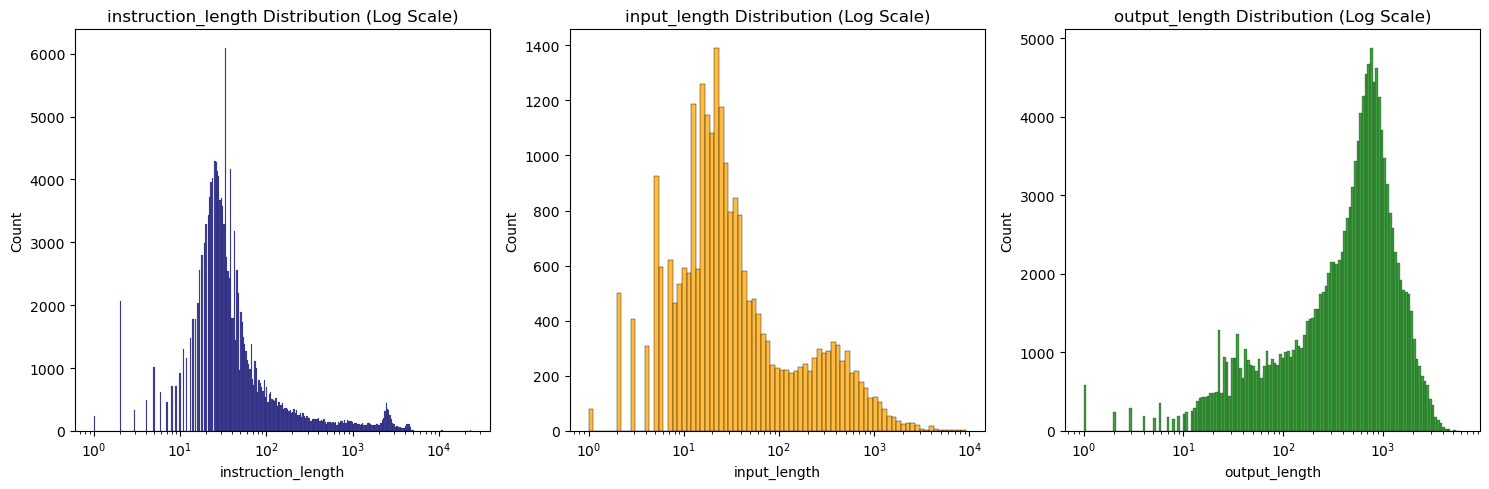

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 로그 스케일을 적용하고 막대기 색상을 설정한 히스토그램 생성
plt.figure(figsize=(15, 5))

# 색상 정의
colors = ['navy', 'orange', 'green']

# 각 열에 대해 히스토그램 그리기
for i, column in enumerate(['instruction_length', 'input_length', 'output_length']):
    plt.subplot(1, 3, i + 1)
    sns.histplot(df[column], kde=False, log_scale=(True), color=colors[i]) # Y축만 로그
    plt.title(f'{column} Distribution (Log Scale)')

plt.tight_layout()
plt.show()


### 커널 밀도 추정(KDE) 시각화 (Instruction Length vs Output Length):
- 'instruction_length'와 'output_length' 간의 관계를 보여줍니다.
- 데이터 포인트의 밀도를 추정하여 표현하는 플롯입니다. KDE 플롯은 데이터 분포의 "스무드(smoother)"한 버전을 제공합니다.


<Figure size 1000x600 with 0 Axes>

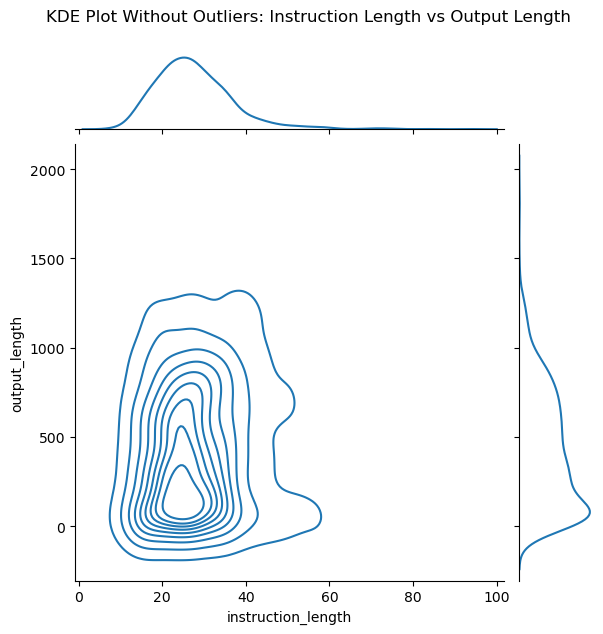

In [13]:
# KDE 플롯 생성
df_sample = df.head(2000) #시각화 실습시간을 위해 셈플링한 데이터만 수행했습니다. 


# 1사분위수(Q1)와 3사분위수(Q3) 계산 (숫자형 열만)
Q1 = df.quantile(0.25, numeric_only=True)
Q3 = df.quantile(0.75, numeric_only=True)
IQR = Q3 - Q1

# 숫자형 열만 선택
numeric_columns = df_sample.select_dtypes(include=[np.number])

# 아웃라이어를 제외한 데이터 필터링 (숫자형 열에 대해서만)
filtered_df = df_sample[~((numeric_columns < (Q1 - 1.5 * IQR)) |(numeric_columns > (Q3 + 1.5 * IQR))).any(axis=1)]

# 필터링된 데이터로 KDE 플롯 생성
plt.figure(figsize=(10, 6))
sns.jointplot(data=filtered_df, x='instruction_length', y='output_length', kind='kde')
plt.suptitle('KDE Plot Without Outliers: Instruction Length vs Output Length', y=1.05)
plt.show()


### 질문문장의 고유명사의 빈도수를 추출
- 파인튜닝 하기 위한 특정 고유명사들이 입력 학습 데이터에 충분히 들어있는지 확인해봅니다. 
- konlpy 라이브러리의 Hannanum,Okt 등의 클래스를 사용하여 한글 텍스트에서 명사를 추출할 수 있습니다. 


In [14]:
!pip install konlpy

In [15]:
from konlpy.tag import Hannanum
from collections import Counter

df_sample = df.head(2000) #시각화 실습시간을 위해 셈플링한 데이터만 수행했습니다.

# Hannanum 객체 생성
hannanum = Hannanum()

# 한글 텍스트가 포함된 열 선택 (예시: 'instruction'이라는 열 이름 가정)
text_data = df_sample['instruction']

# 모든 문장에서 명사 추출 및 빈도수 계산
word_counts = Counter()

for text in text_data:
    # 텍스트에서 명사 추출
    nouns = hannanum.nouns(text)
    word_counts.update(nouns)

# 가장 흔한 단어 및 빈도수 출력
for word, count in word_counts.most_common(10):
    print(f"{word}: {count}")


다음: 359
문장: 337
설명: 278
작성: 254
생성: 168
단어: 132
사용: 129
목록: 125
수: 113
가지: 96


In [16]:
print(df.columns)

Index(['id', 'instruction', 'input', 'output', 'instruction_length',
       'input_length', 'output_length'],
      dtype='object')


### 문장 길이, 단어 빈도 등을 시각화

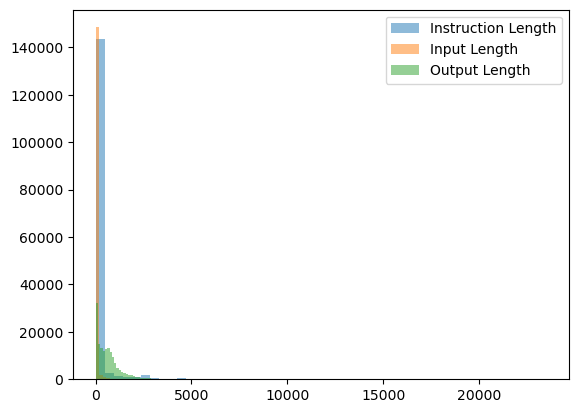

In [17]:
import matplotlib.pyplot as plt

# 문장 길이 분포 시각화
plt.hist(df['instruction_length'], bins=50, alpha=0.5, label='Instruction Length')
plt.hist(df['input_length'], bins=50, alpha=0.5, label='Input Length')
plt.hist(df['output_length'], bins=50, alpha=0.5, label='Output Length')
plt.legend(loc='upper right')
plt.show()

### 고유 단어 및 빈도수 분석

In [18]:
from collections import Counter

# 모든 문장을 단어로 분리
all_words = ' '.join(df['instruction']).split()

# 단어 빈도수 계산
word_freq = Counter(all_words)

# 가장 자주 등장하는 단어 10개
print('가장 자주 등장하는 단어 10개 : ', word_freq.most_common(10))
print('\n')
# 가장 드물게 등장하는 단어 10개
print('가장 드물게 등장하는 단어 10개 : ', word_freq.most_common()[:-11:-1])


가장 자주 등장하는 단어 10개 :  [('수', 54541), ('=', 37405), ('대한', 30755), ('이', 25735), ('및', 25516), ('있는', 22676), ('있습니다.', 18468), ('-', 16558), ('더', 15042), ('{', 14709)]


가장 드물게 등장하는 단어 10개 :  [('바이러스에만', 1), ('항바이러스제는', 1), ('PDF에는', 1), ('퇴직입니다(오프보딩과', 1), ('이벤트)으로', 1), ('결혼,', 1), ('오프보딩까지,', 1), ('순간(온보딩부터', 1), ('Peter의', 1), ('신규자', 1)]


<br>

## 2. Tokenize
---
목적: 텍스트를 더 작은 부분, 즉 "토큰(token)"으로 분리하는 과정입니다.토큰화의 주요 목적은 텍스트 데이터를 단순화하는 것입니다. 긴 텍스트를 더 작은 단위로 나누어 알고리즘이 언어를 처리하고 이해하기 쉽게 만듭니다. 토큰은 언어를 이해하는 기반을 마련합니다. 이 토큰들을 분석함으로써, 알고리즘은 문장의 의미를 해석하고 단어가 사용된 맥락을 이해할 수 있습니다.
단위: 보통 단어, 문장, 문단 등을 토큰으로 분리합니다. 하지만 언어와 문맥에 따라 다를 수 있습니다.

### NLP에서 Tokenization

#### Tokenization (토큰화)

**정의**: 토큰화는 큰 문단을 문장, 단어 또는 다른 단위로 분해하는 과정입니다. 이 과정은 텍스트의 구조를 이해하는 데 필수적이며, 자연어 처리(NLP)에서 종종 첫 번째 단계 중 하나입니다.

**사용 사례**: 
- 텍스트 분류
- 감정 분석
- 기계 번역

**예시**: 
```text
입력: "안녕하세요, 세상! 어떻게 지내세요?"
토큰: ["안녕하세요", ",", "세상", "!", "어떻게", "지내세요", "?"]
```

**장점**:
- 단순하고 빠름
- 추가적인 텍스트 분석의 기초가 됨. 토큰화는 필터링, 정규화, 어간 추출(stemming) 및 표제어 추출(lemmatization) 같은 후속 데이터 전처리 단계의 기초를 제공합니다.
- 토큰화를 통해 언어의 구문론적(syntactic) 및 의미론적(semantic) 특성을 파악할 수 있습니다. 이는 품사 태깅, 개체명 인식 등의 고급 NLP 작업에 필수적입니다.
- 토큰화는 언어 모델이 텍스트를 효과적으로 이해하고 생성할 수 있게 도와줍니다. 이는 기계 번역, 감성 분석, 문서 요약 등의 작업에서 중요합니다.

**단점**:
- 단어 사이의 문맥과 의미 관계를 잃음
- 새롭게 생겨나는 신조어, 속어, 인터넷 용어 등은 기존의 토큰화 도구에서 제대로 인식되지 않을 수 있습니다.
- 단어들이 독립적으로 처리될 때 그 문맥상의 의미나 뉘앙스가 무시되기 쉽습니다.
- 관용 표현을 잘 처리하지 못할 수 있음

---

### tokenize 함수
- 주어진 텍스트(prompt)를 토큰화하는 역할을 합니다.
- 토큰화된 결과는 cutoff_len으로 정의된 최대 길이로 제한합니다.

### generate_and_tokenize_prompt 함수 
- 데이터를 바탕으로 프롬프트를 생성하고 토큰화하는 역할을 합니다.
- 학습 데이터를 모델에 적합한 형태로 변환하는 데 사용합니다.

In [19]:
def tokenize(prompt, add_eos_token=True):
    # there's probably a way to do this with the tokenizer settings
    # but again, gotta move fast
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=cutoff_len,
        padding=False,
        return_tensors=None,
    )
    if (
        result["input_ids"][-1] != tokenizer.eos_token_id
        and len(result["input_ids"]) < cutoff_len
        and add_eos_token
    ):
        result["input_ids"].append(tokenizer.eos_token_id)
        result["attention_mask"].append(1)

    result["labels"] = result["input_ids"].copy()

    return result

def generate_and_tokenize_prompt(data_point):
    full_prompt = prompter.generate_prompt(
        data_point["instruction"],
        data_point.get("input"),
        data_point["output"],
    )
    tokenized_full_prompt = tokenize(full_prompt)
    if not train_on_inputs:
        user_prompt = prompter.generate_prompt(data_point["instruction"], data_point.get("input"))
        tokenized_user_prompt = tokenize(user_prompt, add_eos_token=add_eos_token)
        user_prompt_len = len(tokenized_user_prompt["input_ids"])

        if add_eos_token:
            user_prompt_len -= 1

        tokenized_full_prompt["labels"] = [-100] * user_prompt_len + tokenized_full_prompt["labels"][
            user_prompt_len:
        ]  # could be sped up, probably
    return tokenized_full_prompt


In [20]:
dataset = data['train'].shuffle()#.select(range(100))
lm_dataset = dataset.map(generate_and_tokenize_prompt)

# Print total number of samples
print(f"Total number of samples: {len(lm_dataset)}")

Parameter 'function'=<function generate_and_tokenize_prompt at 0x7f161acbb5b0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/152630 [00:00<?, ? examples/s]

Total number of samples: 152630


In [24]:
df_lm = lm_dataset.to_pandas()
df_lm

,id,instruction,input,output,input_ids,attention_mask,labels
0,vicuna_{idx},이 코드는 마이어의 싱글톤을 구현한 코드입니다:#include Singleton 클...,,"예, 싱글톤 클래스의 인스턴스인 `inst` 변수를 호출하는 것이 적절합니다. 인스...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ..."
1,alpaca_{idx},이 에세이 초안에서 개선해야 할 점은 무엇인가요?,"정부는 수년 동안 환경 보호를 위한 법률을 통과시켜 왔습니다. 오염을 줄이고, 남획...","에세이 초안을 좀 더 발전시키고 정교화하면 도움이 될 수 있습니다. 예를 들어, 정...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ..."
2,alpaca_{idx},사막 기후에 사는 사람이 비상 키트에 갖춰야 할 10가지 물품 목록을 생성합니다.,,사막 기후에 사는 사람이 비상 키트에 갖춰야 할 10가지 품목을 소개합니다:\n\n...,"[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ..."
3,vicuna_{idx},구체화 된 뷰를 만든 직후에 \*에서 \*를 선택하면 어떤 출력이 출력되는지 예를 ...,,앞서 제공된 쿼리를 사용하여 구체화된 뷰를 만든 직후에 `SELECT * FROM ...,"[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ..."
4,vicuna_{idx},20년 동안 파이썬과 파이썬 코딩을 가르치셨으니 여전히 온라인 파이썬 강좌 강사로 ...,,은행 업계를 위한 3일간의 온라인 파이썬 강좌에서 다룰 수 있는 5가지 문제 영역은...,"[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ..."
...,...,...,...,...,...,...,...
152625,vicuna_{idx},NO-CORS FETCH JS 응답을 얻는 방법,,no-cors` 모드로 `fetch()` 요청을 할 경우 CORS 정책 제한으로 인...,"[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ..."
152626,alpaca_{idx},"이 문장을 개선하기 위해 세 가지 변경 사항을 제안합니다: ""현명한 생각이라고 생각...",,"1. ""나는 그것이 현명한 생각이라고 생각하지 않습니다.""와 같이 축약어를 변경하여...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ..."
152627,vicuna_{idx},VS 코드에서 코딩하는 10장의 세부 사항,,10장: 프록시 서버로 NGINX 사용하기이 챕터에서는 Angular 앱 앞의 프록...,"[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ..."
152628,alpaca_{idx},다음 문장을 구문 분석하고 주어진 구조에 대한 사전을 만듭니다.,잭은 뉴욕에서 온 21세 학생입니다.,"다음은 주어진 문장에 대해 가능한 사전 구조입니다:\n\n```\n{\n ""이...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ..."


In [25]:
# 'input_ids' 칼럼의 각 벡터의 길이를 새로운 칼럼 'input_ids_length'에 저장
df_lm['input_ids_length'] = df_lm['input_ids'].apply(len)

# 새로운 칼럼을 확인
df_lm

,id,instruction,input,output,input_ids,attention_mask,labels,input_ids_length
0,vicuna_{idx},이 코드는 마이어의 싱글톤을 구현한 코드입니다:#include Singleton 클...,,"예, 싱글톤 클래스의 인스턴스인 `inst` 변수를 호출하는 것이 적절합니다. 인스...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...",680
1,alpaca_{idx},이 에세이 초안에서 개선해야 할 점은 무엇인가요?,"정부는 수년 동안 환경 보호를 위한 법률을 통과시켜 왔습니다. 오염을 줄이고, 남획...","에세이 초안을 좀 더 발전시키고 정교화하면 도움이 될 수 있습니다. 예를 들어, 정...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...",307
2,alpaca_{idx},사막 기후에 사는 사람이 비상 키트에 갖춰야 할 10가지 물품 목록을 생성합니다.,,사막 기후에 사는 사람이 비상 키트에 갖춰야 할 10가지 품목을 소개합니다:\n\n...,"[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...",343
3,vicuna_{idx},구체화 된 뷰를 만든 직후에 \*에서 \*를 선택하면 어떤 출력이 출력되는지 예를 ...,,앞서 제공된 쿼리를 사용하여 구체화된 뷰를 만든 직후에 `SELECT * FROM ...,"[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...",319
4,vicuna_{idx},20년 동안 파이썬과 파이썬 코딩을 가르치셨으니 여전히 온라인 파이썬 강좌 강사로 ...,,은행 업계를 위한 3일간의 온라인 파이썬 강좌에서 다룰 수 있는 5가지 문제 영역은...,"[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...",693
...,...,...,...,...,...,...,...,...
152625,vicuna_{idx},NO-CORS FETCH JS 응답을 얻는 방법,,no-cors` 모드로 `fetch()` 요청을 할 경우 CORS 정책 제한으로 인...,"[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...",372
152626,alpaca_{idx},"이 문장을 개선하기 위해 세 가지 변경 사항을 제안합니다: ""현명한 생각이라고 생각...",,"1. ""나는 그것이 현명한 생각이라고 생각하지 않습니다.""와 같이 축약어를 변경하여...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...",172
152627,vicuna_{idx},VS 코드에서 코딩하는 10장의 세부 사항,,10장: 프록시 서버로 NGINX 사용하기이 챕터에서는 Angular 앱 앞의 프록...,"[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...",1163
152628,alpaca_{idx},다음 문장을 구문 분석하고 주어진 구조에 대한 사전을 만듭니다.,잭은 뉴욕에서 온 21세 학생입니다.,"다음은 주어진 문장에 대해 가능한 사전 구조입니다:\n\n```\n{\n ""이...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...",162


#### 토크나이징 벡터의 최대 길이는 설정한 cutoff_len로 고정됨

In [26]:
# 'input_ids_length' 칼럼의 최대값을 확인
max_value = df_lm['input_ids_length'].max()

print(f"The maximum length of 'input_ids' is {max_value}")

The maximum length of 'input_ids' is 2048


<br>

## 3. Save dataset to S3
---

In [27]:
import sagemaker
import boto3
sess = sagemaker.Session()
region = boto3.Session().region_name
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
bucket = None
if bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=bucket)

print(f"SageMaker role arn: {role}")
print(f"SageMaker bucket: {sess.default_bucket()}")
print(f"SageMaker session region: {sess.boto_region_name}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
SageMaker role arn: arn:aws:iam::334816520966:role/sagemaker-immersion-day-SageMakerExecutionRole-QMhudTJnrvaX
SageMaker bucket: sagemaker-us-east-1-334816520966
SageMaker session region: us-east-1


In [28]:
bucket_prefix = 'ko-llms/peft'
dataset_prefix = 'alpaca-train'
dataset_prefix_all = 'alpaca-train-all'

s3_data_path = f"s3://{bucket}/{bucket_prefix}/{model_name}/dataset/{dataset_prefix}"
s3_pretrained_model_path = f"s3://{bucket}/{bucket_prefix}/huggingface-models/{model_name}/"
print(f"S3 data path: \n {s3_data_path}")
print(f"S3 pretrained model path: \n {s3_pretrained_model_path}")

S3 data path: 
 s3://sagemaker-us-east-1-334816520966/ko-llms/peft/kullm-polyglot-12-8b-v2/dataset/alpaca-train
S3 pretrained model path: 
 s3://sagemaker-us-east-1-334816520966/ko-llms/peft/huggingface-models/kullm-polyglot-12-8b-v2/


### 로컬학습을 위한 데이터셋 저장
- dataset_prefix : 디버깅을 위한 처음 50개의 샘플(num_debug_samples)을 선택하여 dataset_prefix에 지정된 경로에 저장합니다. 
- dataset_prefix_all : 152630개를 모두 학습에 사용합니다. 

In [29]:
num_debug_samples = 50
lm_dataset.save_to_disk(s3_data_path)
lm_dataset.select(range(num_debug_samples)).save_to_disk(dataset_prefix)

lm_dataset.save_to_disk(dataset_prefix_all)
print(f"Number of samples for debugging: {num_debug_samples}")

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/fsspec/registry.py:272: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


Saving the dataset (0/3 shards):   0%|          | 0/152630 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/50 [00:00<?, ? examples/s]

Saving the dataset (0/3 shards):   0%|          | 0/152630 [00:00<?, ? examples/s]

Number of samples for debugging: 50


In [30]:
%store bucket_prefix dataset_prefix s3_data_path dataset_prefix_all

Stored 'bucket_prefix' (str)
Stored 'dataset_prefix' (str)
Stored 's3_data_path' (str)
Stored 'dataset_prefix_all' (str)
